In [ ]:
# !pip install mediapipe

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

## KEYPOINT EXTRACTION

In [2]:
mp

<module 'mediapipe' from 'H:\\PYTHON\\PYTHON SYSTEM FILES\\Lib\\site-packages\\mediapipe\\__init__.py'>

In [3]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [4]:
mp_holistic

<module 'mediapipe.python.solutions.holistic' from 'H:\\PYTHON\\PYTHON SYSTEM FILES\\Lib\\site-packages\\mediapipe\\python\\solutions\\holistic.py'>

In [5]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False                  
    results = model.process(image)                
    image.flags.writeable = True                   
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results

In [6]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # right hand connections

In [7]:
def draw_styled_landmarks(image, results):
    
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
      
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [8]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])


In [9]:
468*3+33*4+21*3+21*3

1662

## DATA ARRANGEMENT

In [10]:
# !pip install moviepy

In [11]:
DATA_PATH = os.path.join('data2') 

# Actions that we try to detect
actions = np.array(['happy','sad','anger','surprise','fear','neutral'])
actions.sort()

# 62 videos
no_sequences = 75

# 30 frames
sequence_length = 30

#start new folder after 30 frames for data prep
start_folder = 30

## Preprocess Data and Create Labels and Features

In [12]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [13]:
label_map = {label:num for num, label in enumerate(actions)}

In [14]:
label_map

{'anger': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5}

In [15]:
DATA_PATH

'data2'

In [16]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [17]:
np.array(sequences).shape

(450, 30, 1662)

In [18]:
np.array(labels).shape

(450,)

In [19]:
X = np.array(sequences)

In [20]:
X.shape

(450, 30, 1662)

In [21]:
y = to_categorical(labels).astype(int)

In [22]:
y

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]])

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [24]:
y_test.shape

(23, 6)

## Build Network

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from keras import backend as K

In [26]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [5]:
import tensorflow as tf

In [28]:
class CustomAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(CustomAttention, self).__init__()

    def build(self, input_shape):
        super(CustomAttention, self).build(input_shape)

    def call(self, q, k, v):
       
        attention_scores = tf.matmul(q, k, transpose_b=True)
        attention_scores = tf.nn.softmax(attention_scores, axis=-1)
        
        output = tf.matmul(attention_scores, v)
        
        average_attention_score = tf.reduce_mean(attention_scores)
        
        return output, attention_scores, average_attention_score

In [29]:
model = Sequential()
# model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
# LSTM layer
lstm_layer = LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662), return_state=True)
output, state_h, state_c = lstm_layer(X_train) 

attention_layer = CustomAttention()
output, attention_scores, average_attention_score = attention_layer(output, output, output)
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [30]:
# model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
average_attention_score

<tf.Tensor: shape=(), dtype=float32, numpy=0.033333335>

In [24]:
def custom_reward(y_true, y_pred, average_attention_score):
    correct_predictions = tf.reduce_sum(y_true * y_pred)
    
    mean_pred_axis_0 = tf.reduce_mean(y_pred, axis=0)
    mean_pred_axis_1 = tf.reduce_mean(y_pred, axis=1, keepdims=True)
    diversity_penalty = tf.norm(mean_pred_axis_0 - mean_pred_axis_1, ord=2)

    weighted_mistakes_penalty = tf.reduce_sum(tf.square(y_true - y_pred) * tf.constant([1.0, 1.2, 1.5, 1.0, 1.3, 1.5]))
    
    external_metric_bonus = 0.4

    reward = correct_predictions - 0.1 * diversity_penalty - 0.3 * weighted_mistakes_penalty + 0.4 * external_metric_bonus + 0.2 * average_attention_score

    return reward

In [25]:
def custom_loss_with_reward(y_true, y_pred):
    y_true = K.cast(y_true, dtype=K.dtype(y_pred))
    loss = K.categorical_crossentropy(y_true, y_pred)
    
    # Modify to get the average_attention_score from the attention layer
    _, _, average_attention_score = attention_layer(y_pred, y_pred, y_pred)
    
    reward = custom_reward(y_true, y_pred, average_attention_score)
    
    return loss - 0.1 * reward

In [33]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)

In [34]:
model.compile(optimizer=optimizer, loss=custom_loss_with_reward, metrics=['categorical_accuracy'])

In [35]:
X_train.shape,y_train.shape

((427, 30, 1662), (427, 6))

In [37]:
history = model.fit(X_train, y_train, epochs=100, callbacks=[tb_callback])

Epoch 1/100
14/14 [==============================] - 6s 281ms/step - loss: 5.6102 - categorical_accuracy: 0.1569
Epoch 2/100
14/14 [==============================] - 4s 299ms/step - loss: 3.3394 - categorical_accuracy: 0.2248
Epoch 3/100
14/14 [==============================] - 4s 286ms/step - loss: 4.7967 - categorical_accuracy: 0.1897
Epoch 4/100
14/14 [==============================] - 4s 292ms/step - loss: 5.8490 - categorical_accuracy: 0.1780
Epoch 5/100
14/14 [==============================] - 4s 299ms/step - loss: 2.6526 - categorical_accuracy: 0.1967
Epoch 6/100
14/14 [==============================] - 4s 290ms/step - loss: 2.3805 - categorical_accuracy: 0.2342
Epoch 7/100
14/14 [==============================] - 4s 283ms/step - loss: 2.0706 - categorical_accuracy: 0.3044
Epoch 8/100
14/14 [==============================] - 4s 293ms/step - loss: 1.7617 - categorical_accuracy: 0.2951
Epoch 9/100
14/14 [==============================] - 4s 276ms/step - loss: 1.3915 - categorical_

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 30, 128)           916992    
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 6)                 198       
                                                                 
Total params: 972838 (3.71 MB)
Trainable params: 972838 (3.71 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


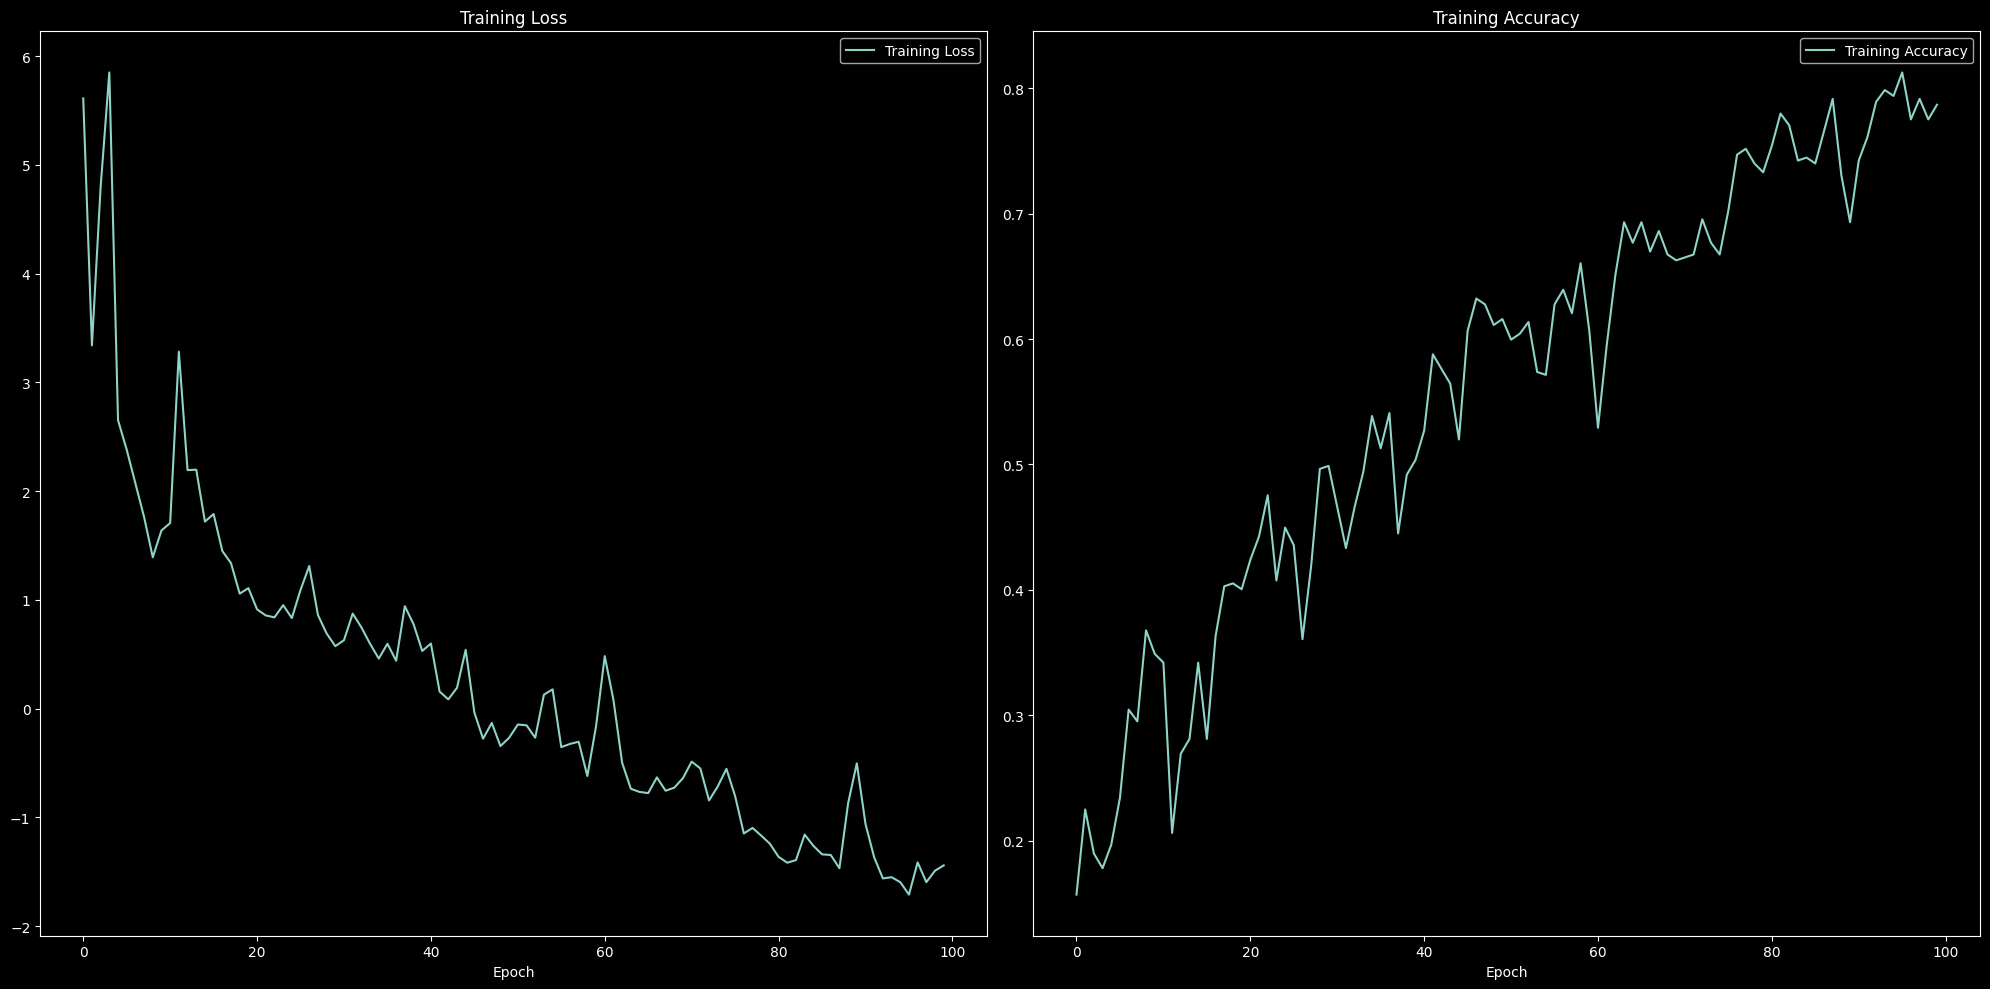

In [39]:
plt.style.use('dark_background')

# Plot loss and accuracy graphs
plt.figure(figsize=(20, 10))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [40]:
y_p = model.predict(X_test)

1/1 [==============================] - 1s 1s/step


In [41]:
y_p.shape

(23, 6)

In [42]:
y_test.shape

(23, 6)

In [43]:
# def calculate_reward(y_true, y_pred):
#     # Correct Predictions
#     correct_predictions = np.sum(y_true * y_pred)

#     # Diversity Penalty
#     mean_pred_axis_0 = np.mean(y_pred, axis=0)
#     mean_pred_axis_1 = np.mean(y_pred, axis=1).reshape(-1, 1)  # Reshape to (19, 1)
#     diversity_penalty = np.linalg.norm(mean_pred_axis_0 - mean_pred_axis_1, ord=2)
#     diversity_penalty = np.linalg.norm(mean_pred_axis_0 - mean_pred_axis_1, ord=2)

#     # Weighted Mistakes Penalty
#     weighted_mistakes_penalty = np.sum(np.square(y_true - y_pred) * np.array([1.0, 2.0, 1.5, 1.0, 2.0, 1.5]))

#     # External Metric Bonus
#     external_metric_bonus = 0.2

#     # Final Reward
#     reward = correct_predictions - 0.1 * diversity_penalty - 0.5 * weighted_mistakes_penalty + external_metric_bonus

#     return reward

In [44]:
# calculate_reward(y_test,y_p)

In [45]:
res = model.predict(X_test)

1/1 [==============================] - 0s 145ms/step


In [46]:
X_test

array([[[ 5.62882900e-01,  6.61165237e-01, -1.29911673e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 5.62113404e-01,  6.59873307e-01, -1.25334454e+00, ...,
          4.78120178e-01,  8.86471570e-01, -2.81047206e-02],
        [ 5.60535550e-01,  6.57276034e-01, -1.32486451e+00, ...,
          4.75783885e-01,  8.71778429e-01, -4.90050279e-02],
        ...,
        [ 5.65055966e-01,  6.62214994e-01, -2.14808345e+00, ...,
          4.43750113e-01,  6.29494429e-01, -6.99631544e-03],
        [ 5.68543434e-01,  6.62347376e-01, -2.11186934e+00, ...,
          4.40335304e-01,  6.19898498e-01, -2.32638977e-03],
        [ 5.72032571e-01,  6.61679387e-01, -2.24986696e+00, ...,
          4.38524932e-01,  6.16342902e-01,  9.69342713e-04]],

       [[ 5.22007585e-01,  4.07178968e-01, -8.09923768e-01, ...,
          1.85155362e-01,  8.02704692e-01, -1.01557769e-01],
        [ 5.22029400e-01,  4.03940529e-01, -8.04846108e-01, ...,
          1.81624591e-01,  8.06447625e

In [47]:
res

array([[7.0685238e-01, 8.4760063e-15, 1.5551523e-05, 2.9306838e-01,
        5.8275270e-14, 6.3580403e-05],
       [9.9615341e-01, 3.2594787e-07, 3.6268053e-03, 1.5947400e-04,
        8.2067281e-08, 5.9904527e-05],
       [2.6799034e-04, 8.4176660e-01, 2.7638325e-05, 5.7443083e-07,
        1.5790698e-01, 3.0225692e-05],
       [1.5493579e-02, 1.0791372e-03, 9.8845109e-02, 2.2009509e-03,
        5.5681719e-03, 8.7681305e-01],
       [1.8234411e-03, 4.8632764e-06, 7.6188948e-03, 9.8196453e-01,
        3.5690059e-04, 8.2312943e-03],
       [1.7319608e-05, 3.3073224e-09, 6.1678211e-06, 1.3875829e-08,
        2.6466680e-09, 9.9997652e-01],
       [7.1760095e-03, 1.2766046e-03, 9.0392965e-01, 5.2078161e-04,
        6.9229659e-03, 8.0174111e-02],
       [7.1760095e-03, 1.2766046e-03, 9.0392965e-01, 5.2078161e-04,
        6.9229659e-03, 8.0174111e-02],
       [2.1867983e-02, 2.0421220e-03, 3.0911648e-01, 3.3485703e-03,
        1.0454174e-02, 6.5317065e-01],
       [1.3822138e-03, 5.3663674e-04,

In [51]:
actions[np.argmax(res[3])]

'surprise'

In [50]:
actions[np.argmax(y_test[3])]

'surprise'

In [53]:
# model.save('action_with_Reward_2.h5')
# model.save_weights('action_with_Reward_2_weights.h5')

In [29]:
model = tf.keras.models.load_model("action_with_Reward_2.h5", custom_objects={'custom_loss_with_reward': custom_loss_with_reward})

In [48]:
_, test1, _, test1_label = train_test_split(X, y, test_size=0.30)

In [49]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [50]:
yhat = model.predict(test1)

5/5 [==============================] - 1s 69ms/step


In [51]:
ytrue = np.argmax(test1_label, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [52]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[ 99,   3],
        [  4,  29]],

       [[105,   8],
        [  5,  17]],

       [[112,   5],
        [  4,  14]],

       [[116,   5],
        [  3,  11]],

       [[103,   5],
        [ 10,  17]],

       [[111,   3],
        [  3,  18]]], dtype=int64)

In [53]:
accuracy_score(ytrue, yhat)

0.7851851851851852

In [54]:
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
print(classification_report(ytrue,yhat))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89        33
           1       0.68      0.77      0.72        22
           2       0.74      0.78      0.76        18
           3       0.69      0.79      0.73        14
           4       0.77      0.63      0.69        27
           5       0.86      0.86      0.86        21

    accuracy                           0.79       135
   macro avg       0.77      0.78      0.78       135
weighted avg       0.79      0.79      0.79       135



In [59]:
for num, prob in enumerate(res):
    print(num,prob)

0 [7.0685238e-01 8.4760063e-15 1.5551523e-05 2.9306838e-01 5.8275270e-14
 6.3580403e-05]
1 [9.9615341e-01 3.2594787e-07 3.6268053e-03 1.5947400e-04 8.2067281e-08
 5.9904527e-05]
2 [2.6799034e-04 8.4176660e-01 2.7638325e-05 5.7443083e-07 1.5790698e-01
 3.0225692e-05]
3 [0.01549358 0.00107914 0.09884511 0.00220095 0.00556817 0.87681305]
4 [1.8234411e-03 4.8632764e-06 7.6188948e-03 9.8196453e-01 3.5690059e-04
 8.2312943e-03]
5 [1.7319608e-05 3.3073224e-09 6.1678211e-06 1.3875829e-08 2.6466680e-09
 9.9997652e-01]
6 [7.1760095e-03 1.2766046e-03 9.0392965e-01 5.2078161e-04 6.9229659e-03
 8.0174111e-02]
7 [7.1760095e-03 1.2766046e-03 9.0392965e-01 5.2078161e-04 6.9229659e-03
 8.0174111e-02]
8 [0.02186798 0.00204212 0.30911648 0.00334857 0.01045417 0.65317065]
9 [1.3822138e-03 5.3663674e-04 9.7931653e-01 9.6268646e-05 7.9813320e-03
 1.0687019e-02]
10 [1.0694442e-05 9.3040442e-01 1.1068927e-06 1.2374793e-06 6.9421925e-02
 1.6064053e-04]
11 [7.7508909e-01 3.6537225e-11 2.5777947e-04 2.2427550e-0

In [60]:
from scipy import stats

In [61]:
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245), (255, 0, 0), (0, 255, 0), (0, 0, 255)]

def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        probability_text = f"{prob * 100:.4f}"  # Format probability to display up to 4 decimal points
        label_text = actions[num]
        cv2.putText(output_frame, f"{label_text}: {probability_text}", (0, 85 + num * 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    return output_frame

In [62]:
# prob_viz(res[0], actions, image, colors)

In [63]:
# plt.figure(figsize=(18,18))
# plt.imshow(prob_viz(res[2], actions, image, colors))

In [27]:
import tensorflow as tf

In [28]:
model = tf.keras.models.load_model("action_with_Reward_2.h5", custom_objects={'custom_loss_with_reward': custom_loss_with_reward})

In [71]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture("../happy19.mp4")
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        if not ret or frame is None:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(res)
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        # cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        # cv2.putText(image, ' '.join(sentence), (3,30), 
        #                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

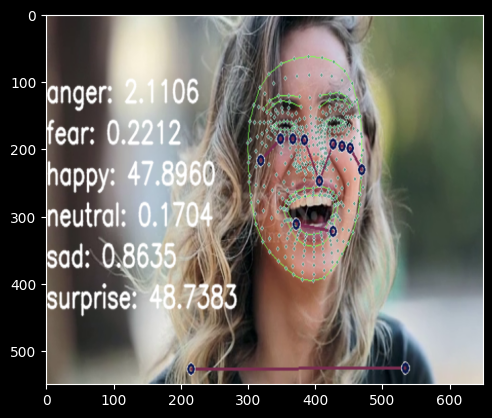

In [82]:
resized_image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (650, 550))
plt.imshow(resized_image)
plt.show()

In [73]:
# history

In [83]:
res

array([0.02110554, 0.00221208, 0.4789604 , 0.00170445, 0.00863484,
       0.4873827 ], dtype=float32)

In [84]:
emo=['happy','sad','anger','surprise','fear','neutral']
emo.sort()
res
for i in range(len(actions)):
    print(emo[i],"---->",res[i])

anger ----> 0.021105543
fear ----> 0.002212075
happy ----> 0.4789604
neutral ----> 0.0017044479
sad ----> 0.008634843
surprise ----> 0.4873827


In [85]:
import numpy as np


# Get the indices of the top 3 elements
top_indices = np.argsort(res)[-2:][::-1]

print("Indices of the top 3 elements:", top_indices)

Indices of the top 3 elements: [5 2]


In [86]:
ans=[]

In [87]:
for i in top_indices:
    ans.append(actions[i])

In [88]:
ans

['surprise', 'happy']

In [89]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture("J:/AUTISM DETECTION PROJECT/3DCNN/videos/sad/sad30.mp4")
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        if not ret or frame is None:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(res)
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        # cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        # cv2.putText(image, ' '.join(sentence), (3,30), 
                       # cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [90]:
res

array([1.9006994e-02, 8.4076142e-01, 6.9634258e-03, 5.1786741e-05,
       1.3275155e-01, 4.6480185e-04], dtype=float32)

In [91]:
emo=['happy','sad','anger','surprise','fear','neutral']
emo.sort()
res
for i in range(len(actions)):
    print(emo[i],"---->",res[i])

anger ----> 0.019006994
fear ----> 0.8407614
happy ----> 0.006963426
neutral ----> 5.178674e-05
sad ----> 0.13275155
surprise ----> 0.00046480185


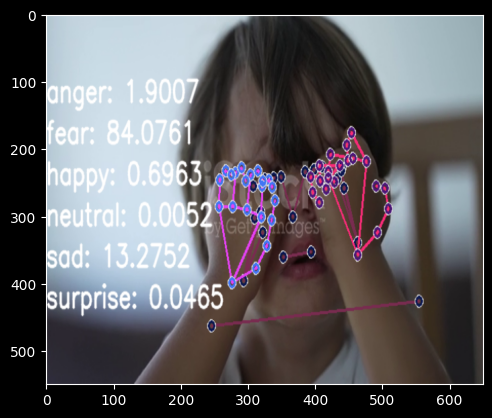

In [95]:
resized_image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (650, 550))
plt.imshow(resized_image)
plt.show()

In [96]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

actions=['happy','sad','anger','surprise','fear','neutral']
actions.sort()

cap = cv2.VideoCapture("../fear20.mp4")
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        if not ret or frame is None:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(res)
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            image = prob_viz(res, actions, image, colors)
            
        # cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        # cv2.putText(image, ' '.join(sentence), (3,30), 
        #                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        cv2.imshow('Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [97]:
res

array([5.0369296e-03, 7.0571637e-01, 3.4587599e-02, 7.9762179e-07,
       2.5464061e-01, 1.7707736e-05], dtype=float32)

In [98]:
for i in range(len(actions)):
    print(actions[i],"---->",float(res[i]))

anger ----> 0.005036929622292519
fear ----> 0.7057163715362549
happy ----> 0.03458759933710098
neutral ----> 7.976217943905795e-07
sad ----> 0.2546406090259552
surprise ----> 1.7707736333250068e-05


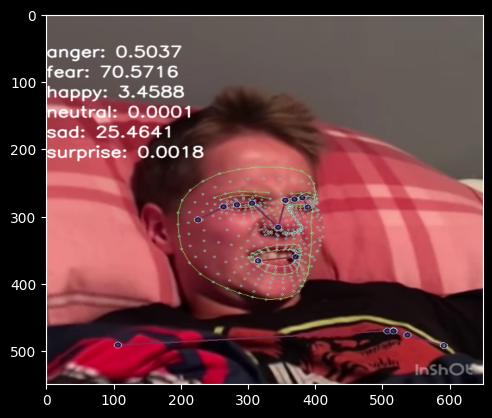

In [99]:
resized_image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (650, 550))
plt.imshow(resized_image)
plt.show()